In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import musicAnalysis as ma

Samples:24000, SR:2000


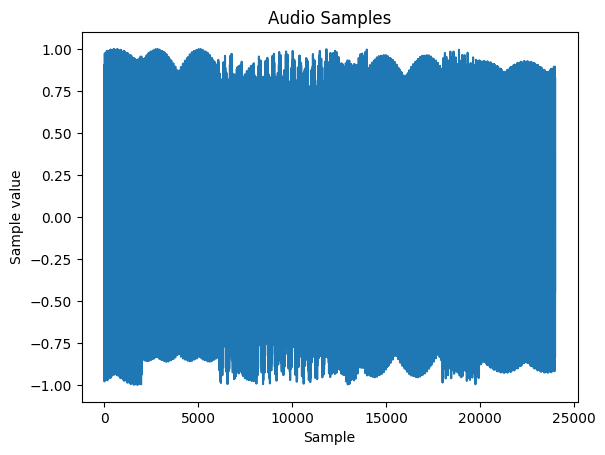

In [2]:
### define parameters for STFT
sr = 2000 
frameSize = 512
hopSize = frameSize//2
midiStart = 55
midiEnd = 80
file = "AmazingGrace.wav"
considerSilence = False # attempt to detect silence in note recognition
topN = 1 # number of notes to attempt to detect in chroma

# ## define parameters for STFT
# sr = 48000 
# frameSize = 8192
# hopSize = frameSize//2
# midiStart = 40
# midiEnd = 80
# file = "MitskiGuitarSolo.wav"
# considerSilence = False # attempt to detect silence in note recognition
# topN = 1 # number of notes to attempt to detect in chroma

### define parameters for STFT
# sr = 8000 
# frameSize = 1024
# hopSize = frameSize//2
# midiStart = 40
# midiEnd = 80
# file = "bass_oboe.wav"
# considerSilence = True
# topN = 1 # number of notes to attempt to detect in chroma

# limit max MIDI to nyquist frequncy
nyquistMidi = int(ma.freqToMIDI(sr/2))
if midiEnd > nyquistMidi:
    midiEnd = nyquistMidi
    
path = r".\Audios\\" + file
wav, sr = ma.loadAudio(path, sr)

ma.playAudio(wav, sr)
print(f'Samples:{len(wav)}, SR:{sr}')
ma.plotAudio(wav, sr=sr)

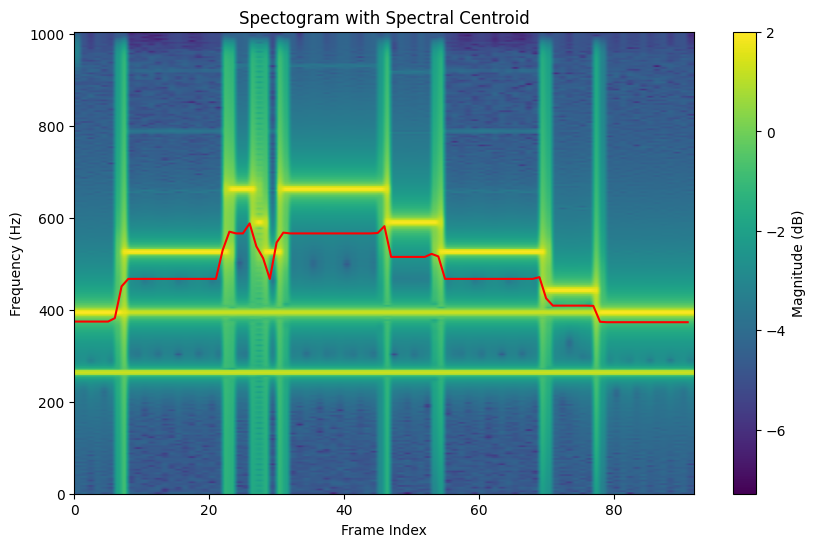

In [3]:
# create STFT
stft = ma.getSTFT(wav, frameSize, hopSize, sr, True)

spectralCentroid = ma.getSpectralCentroid(stft, frameSize, sr)
plt.figure(figsize=(10, 6))
ma.plotSTFT(stft, frameSize, hopSize, sr, freqOnYAxis=True,
            decibelScale=True, showPlot=False, title='Spectogram with Spectral Centroid')
plt.plot(spectralCentroid, 'r')
plt.show()

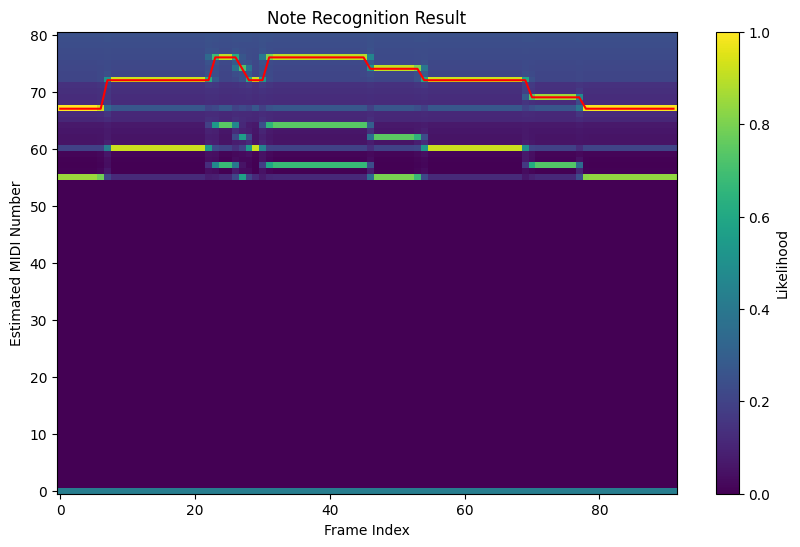

In [4]:
# create templates for chosen MIDI range
all_templates = ma.createTemplates(frameSize, sr, midiStart, midiEnd)

# get likelihood matrix representing likelihood each MIDI being in each frame
likelihoods = ma.getLogLikelihoods(all_templates, stft, midiStart, midiEnd)

# identify most likely notes (or silence) from likelihoods matrix
topNotes_arr = ma.identifyLikelyNotes(likelihoods, considerSilence=considerSilence)

# remove potentially-erroneous noise-influenced note detections
topNotes_arr = ma.removeSpikes(topNotes_arr, 1)

# Set silent notes as NaN to hide the line plot for silent periods
topNotes = np.asarray(topNotes_arr, dtype=np.float32) # allows us to set 0 values to nan
topNotes[topNotes==0] = np.nan # not showing silence (i.e., zeros)

# Plot STFT and most likely note on top
plt.figure(figsize=(10, 6))
img = plt.imshow(likelihoods, origin='lower', aspect='auto')

plt.plot(topNotes, 'r')

# Configure plot
plt.xlabel('Frame Index')
plt.ylabel('Estimated MIDI Number')
plt.title('Note Recognition Result')
plt.colorbar(img, label='Likelihood')
# plt.xlim([0,500])
plt.show()

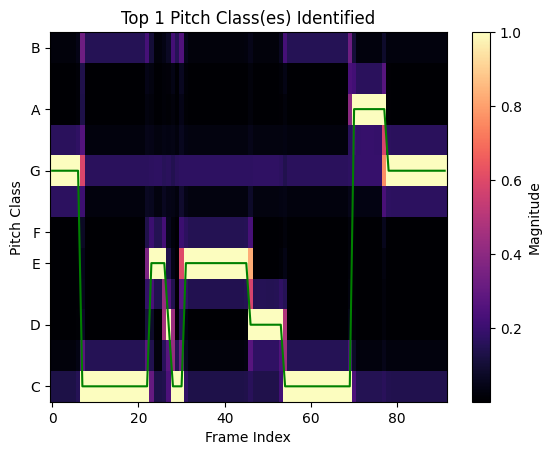

In [5]:
# plt.figure(figsize=(10, 6))
stftMag = np.abs(stft)
chromaSTFT = librosa.feature.chroma_stft(S=stftMag, sr=sr)
chromaImg = librosa.display.specshow(chromaSTFT, y_axis='chroma', x_axis='frames')

# find the top topN values in chromSTFT
maxIdx = np.argpartition(-chromaSTFT, kth=np.arange(topN), axis=0)
# maxVals = np.take_along_axis(likeMatrix, maxIdx, axis=0)[:topN]

# find the topN pitch classes with the highest magnitudes in each frame
topPitches = np.argpartition(-chromaSTFT, kth=np.arange(topN), axis=0)[:topN]
topPitches = np.sort(topPitches, axis=0)

for nIdx in range(topN):
    topPitches[nIdx] = ma.removeSpikes(topPitches[nIdx], 1)

colors = ['g', 'b', 'r', 'cyan', 'k']
for i in range(topN):
    plt.plot(topPitches[i], '-', color=colors[i])

plt.ylim(-0.5, 11.5)
plt.title(f'Top {topN} Pitch Class(es) Identified')
plt.xlabel('Frame Index')
plt.ylabel('Pitch Class')
plt.colorbar(chromaImg, label='Magnitude')
# plt.xlim(150,700)
plt.show()